In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Proj
from cmcrameri import cm
import geopandas as gpd
import netCDF4 as nc
from scipy.interpolate import interp1d
from datetime import datetime

# Read in Data

In [2]:
#works for CG5 output, needs to be changed for CG6
names = ['LINE', 'STATION', 'ALT.', 'GRAV.', 'SD.', 'TILTX', 'TILTY', 'TEMP', 'TIDE', 'DUR', 'REJ', 'TIME', 'DEC.TIME+DATE', 'TERRAIN', 'DATE']
Data = pd.read_csv('example data/T093904.TXT', skiprows=34, names=names, delimiter=r'\s+')

In [4]:
Data = Data.assign(DATE=pd.to_datetime(Data['DATE'], format='%Y/%m/%d'))
Data = Data.assign(DateTime=pd.to_datetime(Data['DATE'].dt.strftime('%Y-%m-%d') 
                                                       + ' ' + Data['TIME'], format='%Y-%m-%d %H:%M:%S'))

Data.loc[:,'DateTime'] = pd.to_datetime(Data['DateTime'])

datetime_values = Data['DateTime'].copy()
datetime_strings = [str(dt) for dt in datetime_values]

reference_time = min(datetime.strptime(dt, '%Y-%m-%d %H:%M:%S') for dt in datetime_strings)
seconds_elapsed = [(datetime.strptime(dt, '%Y-%m-%d %H:%M:%S') - reference_time).total_seconds() for dt in datetime_strings]
Data.loc[:,'seconds_elapsed'] = seconds_elapsed

# Base Station
Data_control = Data[Data.STATION==5000]

C:\Users\00111021\AppData\Local\Temp\ipykernel_26136\277695818.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Data.loc[:,'DateTime'] = pd.to_datetime(Data['DateTime'])


In [5]:
Data.head(2)

,LINE,STATION,ALT.,GRAV.,SD.,TILTX,TILTY,TEMP,TIDE,DUR,REJ,TIME,DEC.TIME+DATE,TERRAIN,DATE,DateTime,seconds_elapsed
0,0.0,5000.0,20.0682,6491.527,0.051,72.9,93.2,-3.43,-0.085,30,0,10:47:19,45283.44881,0.0,2024-01-24,2024-01-24 10:47:19,0.0
1,0.0,5000.0,20.3123,6491.618,0.073,48.4,78.9,-3.50,-0.085,30,0,10:49:36,45283.45039,0.0,2024-01-24,2024-01-24 10:49:36,137.0


# Plot Data

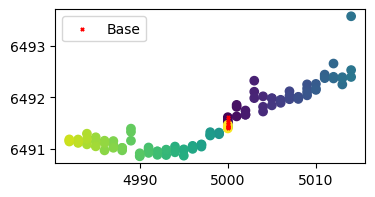

In [6]:
plt.figure(figsize=(4,2))
plt.scatter(Data.STATION, Data['GRAV.'],c=Data['DateTime'])
plt.scatter(Data_control.STATION, Data_control['GRAV.'],marker='x',s=5, color='red', label='Base')
plt.legend()

# Drift

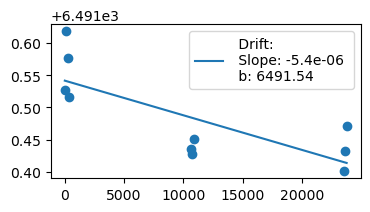

In [7]:
x = np.array(Data_control['seconds_elapsed'])
y = Data_control['GRAV.']
m, b = np.polyfit(x, y, 1) 
slope_label = f" Drift: \n Slope: {m:.1e} \n b: {b:.2f}"

plt.figure(figsize=(4,2))
plt.scatter(x, y)
plt.plot(x, m*x + b, label=slope_label)
plt.legend()

Drift = np.vstack((x, m*x + b)).T

In [8]:
# take mean of three measurements at each location
df = Data[['STATION', 'seconds_elapsed','GRAV.','SD.']]
mean_Data = df.groupby('STATION').mean() 
mean_Data.reset_index(inplace=True)

(930.3333333333334, 21874.666666666668)

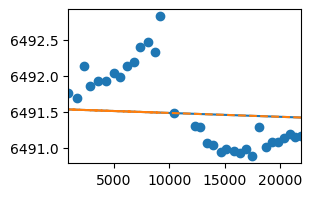

In [74]:
x_new = mean_Data['seconds_elapsed']
f = interp1d(Drift[:,0],Drift[:,1], kind='linear')
y_new = f(x_new)

plt.figure(figsize=(3,2))
plt.plot(Drift[:,0],Drift[:,1])
plt.scatter(mean_Data['seconds_elapsed'], mean_Data['GRAV.'])
plt.plot(x_new,y_new, linestyle='--')
plt.xlim(min(mean_Data['seconds_elapsed']), max(mean_Data['seconds_elapsed']))

# Corrections

In [101]:
np.linspace(0, 1, 3) ,np.linspace(0, 1, 11)

(array([0. , 0.5, 1. ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

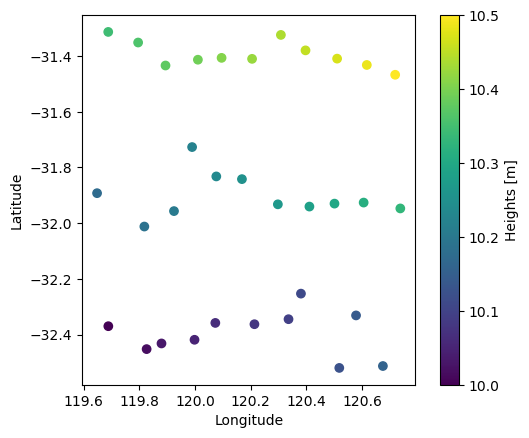

In [107]:
################################### synthetic Lons, Lats, and heights (need to be replaced by real data ########################
Heights=np.linspace(10,10.5,len(mean_Data))

Lon = 119.7
Lat = -32.4

x_grid = np.linspace(0, 1, 11)
y_grid = np.linspace(0, 1, 3)   

x, y = np.meshgrid(x_grid, y_grid)

x_flat = x.flatten()
y_flat = y.flatten()

x_flat += np.random.normal(0, 0.02, len(x_flat)) + Lon  
y_flat += np.random.normal(0, 0.07, len(y_flat)) + Lat  

plt.scatter(x_flat, y_flat, c=Heights)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Heights [m]')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()
#################################################################################################################################

In [108]:
constant = y_new
#drift corrected
mean_Data['g_total'] = mean_Data['GRAV.']- constant
#normal gravity
mean_Data['g_n'] = (1+0.005278895 * np.sin(np.radians(Lat))**2 + 0.000023462* np.sin(np.radians(Lat))**4) # * 978031.846  
# free air anomaly
mean_Data['g_FA'] = mean_Data['g_total'] - mean_Data['g_n'] + (0.3086*Heights) 

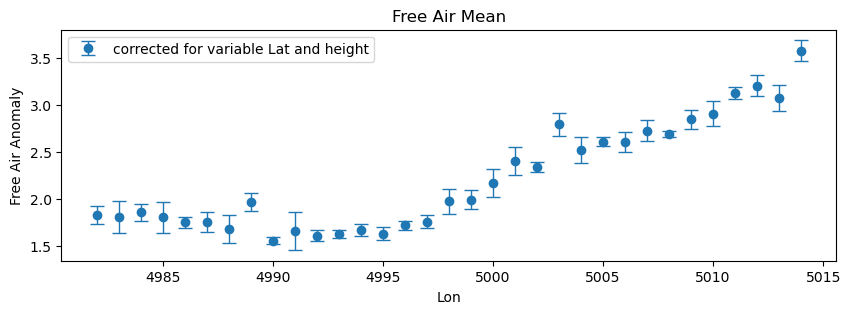

In [109]:
plt.figure(figsize=(10, 3))

plt.errorbar(
    mean_Data['STATION'],
    mean_Data['g_FA'],   
    yerr=mean_Data['SD.'],
    fmt='o',            
    label='corrected for variable Lat and height',
    capsize=5,          
    elinewidth=1
)

plt.title('Free Air Mean')
plt.xlabel('Lon')
plt.ylabel('Free Air Anomaly')
plt.legend()

plt.show()

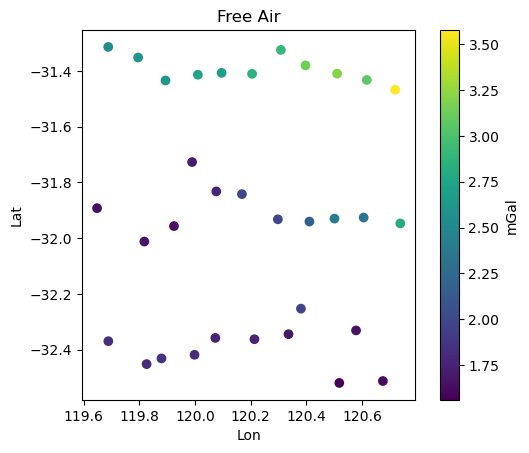

In [110]:
plt.figure()

plt.scatter(x_flat, y_flat,c=mean_Data['g_FA'])

plt.title('Free Air')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar(label='mGal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [111]:
# Save the Data to a CSV file
data_array = np.column_stack((x_flat, y_flat, Heights, mean_Data['g_FA']))
df = pd.DataFrame(data_array, columns=['Lon', 'Lat', 'Height', 'Free air'])
df.to_csv('example data/output_gravity.csv', index=False)